In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Point, box
import geopandas as gpd
from scipy.spatial import cKDTree


# 1. Load CSV files
weather_df = pd.read_csv(r'D:\SVM\Edit 3 SVM\NYC_Weather_2019.csv')
grid_df = pd.read_csv(r'D:\SVM\Edit 3 SVM\nyc_data_cleaned_normalized [Grid ID + Ride Count].csv')

# 2. Convert necessary weather columns to numeric
for col in ['lat', 'lon', 'tmpf', 'relh', 'sped', 'p01i', 'vsby']:
    weather_df[col] = pd.to_numeric(weather_df[col], errors='coerce')

# Fix longitude to be negative if needed
weather_df['lon'] = -weather_df['lon'].abs()

# 3. Handle missing values in weather data
weather_df = weather_df.replace([np.inf, -np.inf], np.nan)
weather_df.dropna(subset=['lat', 'lon', 'tmpf', 'relh', 'sped', 'p01i', 'vsby'], inplace=True)

# 4. Convert weather data to GeoDataFrame
weather_gdf = gpd.GeoDataFrame(
    weather_df,
    geometry=gpd.points_from_xy(weather_df['lon'], weather_df['lat']),
    crs="EPSG:4326"
)

In [3]:
# 5. Handle missing values in grid data
grid_df[['Min Lat', 'Max Lat', 'Min Long', 'Max Long']] = grid_df[['Min Lat', 'Max Lat', 'Min Long', 'Max Long']].astype(float)
grid_df.dropna(subset=['Min Lat', 'Max Lat', 'Min Long', 'Max Long'], inplace=True)

# 6. Create geometry for each grid polygon
grid_df['geometry'] = grid_df.apply(
    lambda row: box(row['Min Long'], row['Min Lat'], row['Max Long'], row['Max Lat']),
    axis=1
)
grid_gdf = gpd.GeoDataFrame(grid_df, geometry='geometry', crs="EPSG:4326")

# 7. Calculate grid center coordinates
grid_gdf['center_lat'] = (grid_gdf['Min Lat'] + grid_gdf['Max Lat']) / 2
grid_gdf['center_lon'] = (grid_gdf['Min Long'] + grid_gdf['Max Long']) / 2

grid_coords = np.vstack((grid_gdf['center_lat'], grid_gdf['center_lon'])).T
weather_coords = np.vstack((weather_gdf['lat'], weather_gdf['lon'])).T

# 8. Use KDTree for fast matching between weather points and grid centers
tree = cKDTree(grid_coords)
distances, indices = tree.query(weather_coords, k=1)

# 9. Assign closest grid to each weather observation
weather_gdf['Grid ID'] = grid_gdf.iloc[indices]['Grid ID'].values

# 10. Merge weather data with grid data
merged_df = pd.merge(weather_gdf, grid_gdf, on='Grid ID', how='left')

# 11. Check the shape of the merged data
print(" Was was successfully merged")
print(" Dataframe's shape: ", merged_df.shape)


 Was was successfully merged
 Dataframe's shape:  (17912, 23)


In [5]:
# 12. Classify weather as Good, Bad, or Moderate
def classify_weather(Tmpf, Relh, WindSpeed, p01i, Vsby):
    if (60 <= Tmpf <= 85 and
        30 <= Relh <= 60 and
        WindSpeed <= 15 and
        p01i == 0 and
        Vsby >= 5):
        return "Good Weather"
    elif (Tmpf < 40 or Tmpf > 95 or
          Relh > 80 or Relh < 20 or
          WindSpeed > 25 or
          p01i > 0.05 or
          Vsby < 2):
        return "Bad Weather"
    else:
        return "Moderate Weather"

# Apply the weather classification
merged_df['Weather Condition'] = merged_df.apply(
    lambda row: classify_weather(row['tmpf'], row['relh'], row['sped'], row['p01i'], row['vsby']),
    axis=1
)

In [7]:
# 13. Save the final merged and classified data to CSV
merged_df.to_csv(r'D:\SVM\Edit 3 SVM\merged_weather_data.csv', index=False)

print("new dataset [merged_weather_data.csv] was stored")

new dataset [merged_weather_data.csv] was stored


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Load the merged data (from previous step)
merged_df = pd.read_csv(r'D:\SVM\Edit 3 SVM\merged_weather_data.csv')

# 2. Preprocess the data

weather_condition_mapping = {'Good Weather': 1, 'Moderate Weather': 2, 'Bad Weather': 3}
merged_df['Weather Condition'] = merged_df['Weather Condition'].map(weather_condition_mapping)

merged_df.dropna(subset=['Ride Count'], inplace=True)

X = merged_df[['tmpf', 'relh', 'sped', 'p01i', 'vsby', 'Weather Condition', 'Ride Count']]  # Features
y = merged_df['Ride Count']  # Target variable

# 3. Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 5. Train the Support Vector Machine (SVM) Model
svm_model = SVR(kernel='rbf')  # Radial Basis Function (RBF) Kernel
svm_model.fit(X_train, y_train)

# 6. Make Predictions
y_pred = svm_model.predict(X_test)

# 7. Evaluate the Model
mse = mean_squared_error(y_test, y_pred)  # Mean Squared Error
r2 = r2_score(y_test, y_pred)  # R-squared

print(" Model was trained")
print(f"Mean Squared Error (MSE): {mse}")


 Model was trained
Mean Squared Error (MSE): 0.0016820637082209007


In [11]:
from sklearn.svm import LinearSVR  # Import LinearSVR instead of SVR

In [13]:
# 9. Classify Good Weather vs Bad Weather using SVM

merged_df['Weather Good/Bad'] = merged_df['Weather Condition'].apply(lambda x: 1 if x == 1 else 0)

# Select features for classification
X_classification = merged_df[['tmpf', 'relh', 'sped', 'p01i', 'vsby', 'Ride Count']]
y_classification = merged_df['Weather Good/Bad']  # Target: Good (1) vs Bad (0)

# Normalize the data for classification
X_classification_scaled = scaler.fit_transform(X_classification)

# Train/Test Split for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_classification_scaled, y_classification, test_size=0.2, random_state=42)

# Train the faster Linear SVM model for classification
svm_classification_model = LinearSVR(max_iter=10000, dual="auto")
svm_classification_model.fit(X_train_class, y_train_class)

# Make predictions for classification
y_pred_class = svm_classification_model.predict(X_test_class)

# Evaluate classification model performance
classification_accuracy = np.mean((y_pred_class > 0.5) == y_test_class)

print(f"Accuracy of Weather Classification Model: {classification_accuracy}")

Accuracy of Weather Classification Model: 0.8671504325983812


In [15]:
# 9. Classify Good Weather vs Bad Weather using SVM

merged_df['Weather Good/Bad'] = merged_df['Weather Condition'].apply(lambda x: 1 if x == 1 else 0)

# Select features for classification
X_classification = merged_df[['tmpf', 'relh', 'sped', 'p01i', 'vsby', 'Ride Count']]
y_classification = merged_df['Weather Good/Bad']  # Target: Good (1) vs Bad (0)

# Normalize the data for classification
X_classification_scaled = scaler.fit_transform(X_classification)

# Train/Test Split for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification_scaled, y_classification, test_size=0.2, random_state=42)

# Train the SVM model for classification
svm_classification_model = SVR(kernel='rbf')
svm_classification_model.fit(X_train_class, y_train_class)

# Make predictions for classification
y_pred_class = svm_classification_model.predict(X_test_class)

# Evaluate classification model performance
classification_accuracy = np.mean((y_pred_class > 0.5) == y_test_class)


print(f"Accuracy of Weather Classification Model: {classification_accuracy}")


Accuracy of Weather Classification Model: 0.9692994697181133


In [17]:
# Predict on training data
y_train_pred_class = svm_classification_model.predict(X_train_class)

# Evaluate training accuracy
train_classification_accuracy = np.mean((y_train_pred_class > 0.5) == y_train_class)

print(f"Training Accuracy of Weather Classification Model: {train_classification_accuracy}")


Training Accuracy of Weather Classification Model: 0.9733407774443437


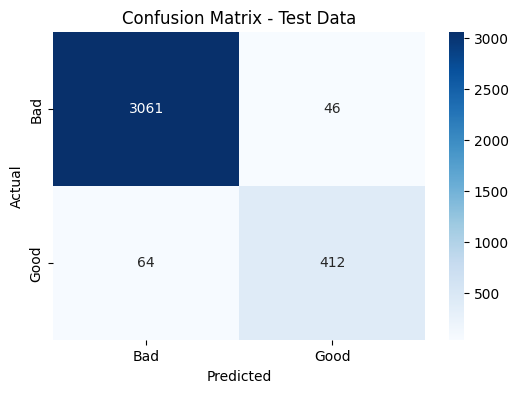

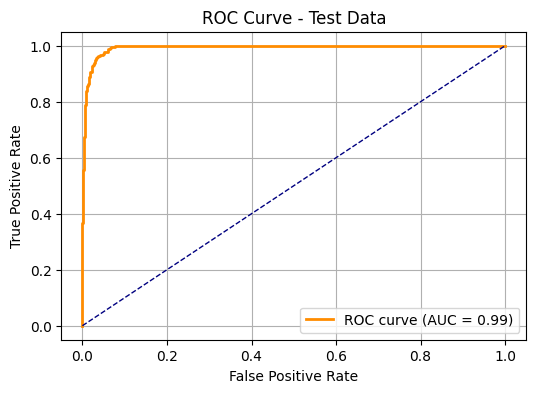

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Class prediction using a 0.5 threshold
y_test_pred_labels = (y_pred_class > 0.5).astype(int)
y_train_pred_labels = (y_train_pred_class > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test_class, y_test_pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad", "Good"], yticklabels=["Bad", "Good"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Data")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_class, y_pred_class)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Data')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [21]:
merged_df['hour'] = pd.to_datetime(merged_df['valid']).dt.hour

merged_df['grid_id'] = (
    (merged_df['lat'] * 10).astype(int).astype(str) + "_" +
    (merged_df['lon'] * 10).astype(int).astype(str)
)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
merged_df['grid_id_encoded'] = le.fit_transform(merged_df['grid_id'])


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Hourly Ridership Prediction Model (Regression)
X_ridership = merged_df[['hour', 'grid_id_encoded', 'tmpf', 'relh', 'p01i', 'vsby', 'Weather Good/Bad']]
y_ridership = merged_df['Ride Count']

# Scale features
X_ridership_scaled = scaler.fit_transform(X_ridership)

# Train/test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_ridership_scaled, y_ridership, test_size=0.2, random_state=42)

svr_model = LinearSVR(max_iter=10000, dual="auto")
svr_model.fit(X_train_r, y_train_r)

# Predict
y_pred_r = svr_model.predict(X_test_r)

# Evaluation metrics
mae = mean_absolute_error(y_test_r, y_pred_r)
rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))

print(" Hourly Ridership Prediction")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")


 Hourly Ridership Prediction
Mean Absolute Error: 0.00
Root Mean Squared Error: 0.00


In [25]:
# 2. Ratio of Good vs Bad Weather Ride Volume
good_weather_rides = merged_df[merged_df['Weather Good/Bad'] == 1]['Ride Count'].mean()
bad_weather_rides = merged_df[merged_df['Weather Good/Bad'] == 0]['Ride Count'].mean()
ride_ratio = good_weather_rides / bad_weather_rides if bad_weather_rides != 0 else np.nan

print("\n Ride Volume Analysis:")
print(f"Avg Rides in Good Weather: {good_weather_rides:.2f}")
print(f"Avg Rides in Bad Weather: {bad_weather_rides:.2f}")
print(f"Ride Volume Ratio (Good / Bad): {ride_ratio:.2f}")



 Ride Volume Analysis:
Avg Rides in Good Weather: 0.14
Avg Rides in Bad Weather: 0.14
Ride Volume Ratio (Good / Bad): 0.99


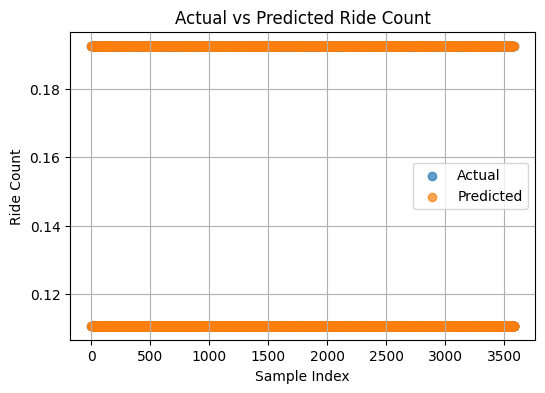

In [27]:
# 3. Visualization of Regression Results
plt.figure(figsize=(6, 4))
plt.scatter(range(len(y_test_r)), y_test_r, label='Actual', alpha=0.7)
plt.scatter(range(len(y_test_r)), y_pred_r, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Ride Count')
plt.xlabel('Sample Index')
plt.ylabel('Ride Count')
plt.legend()
plt.grid(True)
plt.show()

# Note: 
# Performance Bottleneck: SVR(kernel='rbf')

"RBF kernel SVMs are very slow on large datasets due to their complexity "
    "Time complexity: roughly O(n² ~ n³), where n is the number of samples"
    "So with over 200,000 rows, it's likely to freeze, stall, or take hours"

#So first I used: svr_model = SVR(kernel='rbf')
#Then I changed it to: 
#from sklearn.svm import LinearSVR
#svr_model = LinearSVR(max_iter=10000, dual="auto")